# 2D Solver Comparison

Run two 2D wave solvers, measure their runtime, and compare their field outputs on the same grid.

## How to use

1. Edit `shared_parfile_params` in the configuration cell so it contains the full parameter set you want both solvers to run.
2. Make sure every value is compatible with each solver (for example include `frac_bits` if the fixed-point solver needs it).
3. Run the notebook cells in order to execute the solvers, view the runtime summaries, and inspect the error metrics and plots.

All solver outputs are written to solver-specific temporary folders under your system's temp directory so notebook cells can reuse them.

In [1]:
from __future__ import annotations

import os
import math
import re
import subprocess
import sys
import tempfile
import time
import warnings
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Tuple

import h5py
import numpy as np

try:
    import pandas as pd
except ModuleNotFoundError:
    pd = None

import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (7.5, 6), "image.cmap": "coolwarm"})

In [2]:

project_root = Path.cwd()

# Configure the complete parfile to use for every solver run.
shared_parfile_params = {
    "Nt": 2500,
    "Nx": 512,
    "Ny": 512,
    "Xmin": -5,
    "Xmax": 5,
    "Ymin": -5,
    "Ymax": 5,
    "output_interval": 50,
    "cfl": 0.05,
    "bound_cond": "REFLECT",
    "ko_sigma": 0.03125,
    "id_x0": 0,
    "id_y0": 0,
    "id_sigma": 1.0,
    "id_amp": 1.0,
    "frac_bits": 20,
}

solvers_to_compare = [
    {
        "name": "FP64",
        "solver": (project_root / "Solvers/2D_Wave/FP_64_Jax/newSolver.py").as_posix(),
    },
    {
        "name": "Block Floating Point",
        "solver": (project_root / "Solvers/2D_Wave/Block_FP/JaxSolver.py").as_posix(),
    },
]

_JAX_GPU_BACKEND: Optional[str] = None


def _is_jax_solver(spec: Dict[str, object]) -> bool:
    solver_path = Path(spec["solver"])
    lowered = [part.lower() for part in solver_path.parts]
    lowered.append(solver_path.name.lower())
    return any("jax" in part for part in lowered)


def _infer_backend_from_device(dev) -> Optional[str]:
    version = getattr(dev, "platform_version", None)
    if isinstance(version, str) and version:
        token = version.split()[0].lower()
        if token in {"cuda", "rocm"}:
            return token
    kind = getattr(dev, "device_kind", None)
    if isinstance(kind, str):
        lowered = kind.lower()
        if "cuda" in lowered:
            return "cuda"
        if "rocm" in lowered or "amd" in lowered:
            return "rocm"
    client = getattr(dev, "client", None)
    platform = getattr(client, "platform", None)
    if isinstance(platform, str) and platform.lower() in {"cuda", "rocm"}:
        return platform.lower()
    platform_attr = getattr(dev, "platform", None)
    if isinstance(platform_attr, str) and platform_attr.lower() in {"cuda", "rocm"}:
        return platform_attr.lower()
    return None


def _ensure_jax_gpu_ready(solvers: Sequence[Dict[str, object]]) -> Optional[str]:
    global _JAX_GPU_BACKEND
    jax_specs = [spec for spec in solvers if _is_jax_solver(spec)]
    if not jax_specs:
        return None
    backend_override = os.environ.get("JAX_PLATFORMS")
    if backend_override:
        backend_lower = backend_override.lower()
        if backend_lower not in {"cuda", "rocm", "gpu"}:
            raise RuntimeError(
                "JAX_PLATFORMS environment variable is set to an unsupported platform: "
                + backend_override
            )
        _JAX_GPU_BACKEND = backend_lower
        print(
            "JAX GPU check skipped: using pre-set JAX_PLATFORMS="
            f"{os.environ['JAX_PLATFORMS']}."
        )
        return _JAX_GPU_BACKEND
    if _JAX_GPU_BACKEND:
        return _JAX_GPU_BACKEND
    try:
        import jax  # type: ignore[import]
    except ImportError as exc:  # pragma: no cover - informative failure path
        names = ", ".join(str(spec.get("name") or Path(spec["solver"]).stem) for spec in jax_specs)
        raise RuntimeError(
            f"JAX-backed solvers ({names}) require the 'jax' package with GPU support."
        ) from exc
    devices = jax.devices()
    gpu_devices = [dev for dev in devices if getattr(dev, "platform", "") == "gpu"]
    if not gpu_devices:
        platforms = {getattr(dev, "platform", "unknown") for dev in devices} or {"none"}
        raise RuntimeError(
            "Selected solvers require a GPU, but JAX reports available platforms: "
            + ", ".join(sorted(platforms))
        )

    backend_hint: Optional[str] = None
    for dev in gpu_devices:
        backend_hint = _infer_backend_from_device(dev)
        if backend_hint:
            break

    backend_hint = backend_hint or "gpu"
    _JAX_GPU_BACKEND = backend_hint
    device_summaries = ", ".join(f"{dev.device_kind} (id={dev.id})" for dev in gpu_devices)
    print(
        "JAX GPU check passed: "
        f"{len(gpu_devices)} GPU device(s) detected -> {device_summaries} | backend={_JAX_GPU_BACKEND}"
    )
    return _JAX_GPU_BACKEND


for spec in solvers_to_compare:
    solver_path = Path(spec["solver"])
    if not solver_path.exists():
        raise FileNotFoundError(f"Missing solver file: {solver_path}")

_ensure_jax_gpu_ready(solvers_to_compare)


JAX GPU check passed: 1 GPU device(s) detected -> NVIDIA GeForce GTX 1650 (id=0) | backend=gpu


W0113 00:46:50.673938   23506 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0113 00:46:50.696228   23373 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


'gpu'

In [3]:
@dataclass
class SolverRunResult:
    name: str
    solver_path: Path
    runtime: float
    params: Dict[str, object]
    dt: float
    steps: np.ndarray
    times: np.ndarray
    output_dir: Path
    temp_dir: Path
    file_map: Dict[int, Path]
    variables: Tuple[str, ...]
    grid: Dict[str, np.ndarray]
    stdout: str
    stderr: str


def _format_toml_value(value: object) -> str:
    if isinstance(value, str):
        return f'"{value}"'
    if isinstance(value, bool):
        return "true" if value else "false"
    if isinstance(value, (int, float)):
        return repr(value)
    raise TypeError(f"Unsupported parameter type {type(value)!r} for value {value!r}")


def _dump_params(path: Path, params: Dict[str, object]) -> None:
    lines = [f"{key} = {_format_toml_value(value)}" for key, value in params.items()]
    path.write_text("\n".join(lines) + "\n", encoding="utf-8")


def _compute_dt(params: Dict[str, object]) -> float:
    nx = int(params["Nx"])
    ny = int(params["Ny"])
    if nx < 2 or ny < 2:
        raise ValueError("Nx and Ny must be at least 2.")
    x_span = float(params["Xmax"]) - float(params["Xmin"])
    dx = x_span / (nx - 1)
    return float(params.get("cfl", 0.1)) * dx


_STEP_PATTERN = re.compile(r"wave_(\d+)\.h5$")


def _collect_outputs(output_dir: Path) -> Dict[int, Path]:
    files = sorted(output_dir.glob("wave_*.h5"))
    if not files:
        raise FileNotFoundError(f"No HDF5 outputs found in {output_dir}")
    step_map: Dict[int, Path] = {}
    for file_path in files:
        match = _STEP_PATTERN.match(file_path.name)
        if not match:
            continue
        step = int(match.group(1))
        step_map[step] = file_path
    if not step_map:
        raise ValueError(f"No step-indexed outputs matched in {output_dir}")
    return dict(sorted(step_map.items()))


def _read_grid_and_variables(file_path: Path) -> Tuple[Dict[str, np.ndarray], Tuple[str, ...]]:
    with h5py.File(file_path, "r") as h5:
        grid = {axis: h5[axis][()] for axis in ("X", "Y", "Z") if axis in h5}
        variables = tuple(sorted(key for key in h5.keys() if key not in {"X", "Y", "Z"}))
    return grid, variables


def _load_fields(file_path: Path, variables: Sequence[str]) -> Dict[str, np.ndarray]:
    with h5py.File(file_path, "r") as h5:
        return {var: h5[var][()] for var in variables}


def execute_solver(spec: Dict[str, object], base_params: Dict[str, object]) -> SolverRunResult:
    solver_path = Path(spec["solver"]).resolve()
    name = str(spec.get("name") or solver_path.stem)
    extra_params = dict(spec.get("extra_params") or {})

    merged_params = dict(base_params)
    for key, value in extra_params.items():
        if key in merged_params and merged_params[key] != value:
            raise ValueError("extra_params cannot override values from shared_parfile_params; edit the shared config instead.")
        merged_params[key] = value

    temp_dir = Path(tempfile.mkdtemp(prefix=f"{name.lower()}_run_"))
    output_dir = temp_dir / "output"
    merged_params["output_dir"] = output_dir.as_posix()
    tmp_parfile = temp_dir / "params.toml"
    output_dir.mkdir(parents=True, exist_ok=True)
    _dump_params(tmp_parfile, merged_params)

    env = None
    if _is_jax_solver(spec):
        env = dict(os.environ)
        platform_override = spec.get("jax_platform")
        if platform_override is not None:
            requested = str(platform_override).lower()
            if requested not in {"cpu", "gpu", "cuda", "rocm"}:
                raise ValueError(
                    "jax_platform must be one of {'cpu', 'gpu', 'cuda', 'rocm'}, "
                    f"got {platform_override!r}."
                )
            if requested == "cpu":
                env["JAX_PLATFORMS"] = "cpu"
                env["JAX_PLATFORM_NAME"] = "cpu"
            else:
                backend_choice = requested
                if backend_choice == "gpu":
                    backend_choice = _ensure_jax_gpu_ready([spec]) or "gpu"
                else:
                    _ensure_jax_gpu_ready([spec])
                env_backend = "cuda" if backend_choice == "gpu" else backend_choice
                env["JAX_PLATFORMS"] = env_backend
                env["JAX_PLATFORM_NAME"] = "gpu"
        else:
            backend_choice = _ensure_jax_gpu_ready([spec]) or "gpu"
            env_backend = "cuda" if backend_choice == "gpu" else backend_choice
            env["JAX_PLATFORMS"] = env_backend
            env["JAX_PLATFORM_NAME"] = "gpu"

    cmd = [sys.executable, str(solver_path), str(tmp_parfile), str(output_dir)]
    start = time.perf_counter()
    proc = subprocess.run(
        cmd,
        cwd=solver_path.parent,
        text=True,
        capture_output=True,
        check=False,
        env=env,
    )
    runtime = time.perf_counter() - start
    if proc.returncode != 0:
        raise RuntimeError(
            f"Solver {name} failed with exit code {proc.returncode}\nSTDOUT:\n{proc.stdout}\nSTDERR:\n{proc.stderr}"
        )

    step_map = _collect_outputs(output_dir)
    first_output = next(iter(step_map.values()))
    grid, variables = _read_grid_and_variables(first_output)
    dt = _compute_dt(merged_params)
    steps = np.array(list(step_map.keys()))
    times = steps * dt

    return SolverRunResult(
        name=name,
        solver_path=solver_path,
        runtime=runtime,
        params=dict(merged_params),
        dt=dt,
        steps=steps,
        times=times,
        output_dir=output_dir,
        temp_dir=temp_dir,
        file_map=step_map,
        variables=variables,
        grid=grid,
        stdout=proc.stdout,
        stderr=proc.stderr,
    )


def compare_solver_runs(
    run_a: SolverRunResult,
    run_b: SolverRunResult,
    variables: Optional[Sequence[str]] = None,
) -> Dict[str, object]:
    vars_a = set(run_a.variables)
    vars_b = set(run_b.variables)
    if variables is None:
        shared_vars = tuple(sorted(vars_a & vars_b))
    else:
        shared_vars = tuple(sorted(var for var in variables if var in vars_a and var in vars_b))
    if not shared_vars:
        raise ValueError("No common variables found between solvers.")
    if not math.isclose(run_a.dt, run_b.dt, rel_tol=1e-9, abs_tol=1e-12):
        raise ValueError("Time step mismatch; adjust shared_parfile_params so dt matches.")
    for axis in ("X", "Y"):
        ga = run_a.grid.get(axis)
        gb = run_b.grid.get(axis)
        if ga is not None and gb is not None:
            if ga.shape != gb.shape:
                raise ValueError(f"Grid size mismatch detected for axis {axis}.")
            if not np.allclose(ga, gb, rtol=5e-4, atol=1e-5):
                max_diff = float(np.max(np.abs(ga - gb)))
                warnings.warn(
                    f"Minor grid mismatch detected for axis {axis} (max |diff|={max_diff:.3e}). Continuing with reference grid from first solver.",
                    RuntimeWarning,
                )

    shared_steps = sorted(set(run_a.file_map) & set(run_b.file_map))
    if not shared_steps:
        raise ValueError("No common output steps between solvers.")

    per_step: List[Dict[str, float]] = []
    for step in shared_steps:
        data_a = _load_fields(run_a.file_map[step], shared_vars)
        data_b = _load_fields(run_b.file_map[step], shared_vars)
        row: Dict[str, float] = {"step": float(step), "time": float(step * run_a.dt)}
        for var in shared_vars:
            diff = data_a[var] - data_b[var]
            l2 = float(np.sqrt(np.mean(diff ** 2)))
            linf = float(np.max(np.abs(diff)))
            row[f"{var}_l2"] = l2
            row[f"{var}_linf"] = linf
        row["combined_l2"] = float(math.sqrt(sum(row[f"{var}_l2"] ** 2 for var in shared_vars)))
        row["combined_linf"] = float(max(row[f"{var}_linf"] for var in shared_vars))
        per_step.append(row)

    times = np.array([step * run_a.dt for step in shared_steps])
    final = per_step[-1]
    return {
        "variables": shared_vars,
        "steps": shared_steps,
        "times": times,
        "per_step": per_step,
        "final": final,
    }


def plot_field_difference(
    run_a: SolverRunResult,
    run_b: SolverRunResult,
    step: int,
    variable: str,
) -> Tuple[plt.Figure, plt.Axes]:
    if step not in run_a.file_map or step not in run_b.file_map:
        raise KeyError(f"Step {step} not found in both runs.")
    data_a = _load_fields(run_a.file_map[step], (variable,))
    data_b = _load_fields(run_b.file_map[step], (variable,))
    diff = data_a[variable] - data_b[variable]
    x = run_a.grid.get("X")
    y = run_a.grid.get("Y")
    extent = None
    if x is not None and y is not None:
        extent = [float(np.min(x)), float(np.max(x)), float(np.min(y)), float(np.max(y))]
    fig, ax = plt.subplots()
    im = ax.imshow(diff, origin="lower", extent=extent, aspect="auto")
    ax.set_title(f"{variable} difference at step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax, shrink=0.8, label="difference")
    return fig, ax

In [4]:
runs: List[SolverRunResult] = []
for spec in solvers_to_compare:
    print(f"Running {spec['name']} ({spec['solver']})...")
    result = execute_solver(spec, shared_parfile_params)
    runs.append(result)
    print(
        f"  Runtime: {result.runtime:.2f} s | dt={result.dt:.3e} | outputs={len(result.file_map)} | dir={result.output_dir}"
    )

if pd is not None and runs:
    runtime_df = pd.DataFrame(
        {
            "solver": [run.name for run in runs],
            "runtime_s": [run.runtime for run in runs],
            "dt": [run.dt for run in runs],
            "outputs": [len(run.file_map) for run in runs],
            "output_dir": [str(run.output_dir) for run in runs],
        }
    )
    display(runtime_df)
elif runs:
    for run in runs:
        print(
            f"{run.name}: runtime={run.runtime:.2f}s, dt={run.dt:.3e}, outputs={len(run.file_map)}, dir={run.output_dir}"
        )

Running FP64 (/mnt/c/Users/bryso/Documents/GitHub/Rationals/Solvers/2D_Wave/FP_64_Jax/newSolver.py)...
  Runtime: 27.33 s | dt=9.785e-04 | outputs=51 | dir=/tmp/fp64_run_7nxvo4qr/output
Running Block Floating Point (/mnt/c/Users/bryso/Documents/GitHub/Rationals/Solvers/2D_Wave/Block_FP/JaxSolver.py)...
  Runtime: 38.40 s | dt=9.785e-04 | outputs=51 | dir=/tmp/block floating point_run_ca0bsjjd/output


,solver,runtime_s,dt,outputs,output_dir
0,FP64,27.333350,0.000978,51,/tmp/fp64_run_7nxvo4qr/output
1,Block Floating Point,38.401383,0.000978,51,/tmp/block floating point_run_ca0bsjjd/output


In [5]:
comparison_result = None
if len(runs) >= 2:
    run_a, run_b = runs[0], runs[1]
    comparison_result = compare_solver_runs(run_a, run_b)
    if pd is not None:
        comparison_df = pd.DataFrame(comparison_result["per_step"])
        display(comparison_df)
    else:
        for row in comparison_result["per_step"]:
            print(row)
    final = comparison_result["final"]
    print(
        f"Final combined L2={final['combined_l2']:.3e}, combined Linf={final['combined_linf']:.3e}"
    )
else:
    print("Add at least two solvers to compare.")


,step,time,chi_l2,chi_linf,phi_l2,phi_linf,combined_l2,combined_linf
0,0.0,0.000000,0.000000,0.000000,8.865031e-17,8.326673e-16,8.865031e-17,8.326673e-16
1,50.0,0.048924,0.016929,0.191169,4.146211e-04,4.683955e-03,1.693411e-02,1.911686e-01
2,100.0,0.097847,0.033611,0.378620,1.652431e-03,1.864467e-02,3.365187e-02,3.786203e-01
3,150.0,0.146771,0.049807,0.558745,3.695424e-03,4.161135e-02,4.994353e-02,5.587446e-01
4,200.0,0.195695,0.065288,0.728139,6.514090e-03,7.314121e-02,6.561235e-02,7.281390e-01
5,250.0,0.244618,0.079848,0.883704,1.006815e-02,1.126321e-01,8.048051e-02,8.837039e-01
6,300.0,0.293542,0.093304,1.022725,1.430755e-02,1.593393e-01,9.439436e-02,1.022725e+00
7,350.0,0.342466,0.105501,1.142942,1.917366e-02,2.123961e-01,1.072289e-01,1.142942e+00
8,400.0,0.391389,0.116318,1.242602,2.460069e-02,2.708376e-01,1.188911e-01,1.242602e+00
9,450.0,0.440313,0.125670,1.320489,3.051718e-02,3.336261e-01,1.293223e-01,1.320489e+00


Final combined L2=2.116e-01, combined Linf=9.059e-01


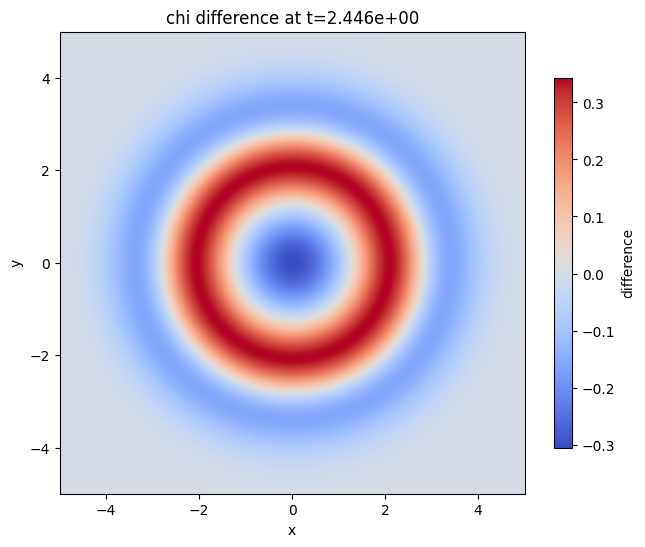

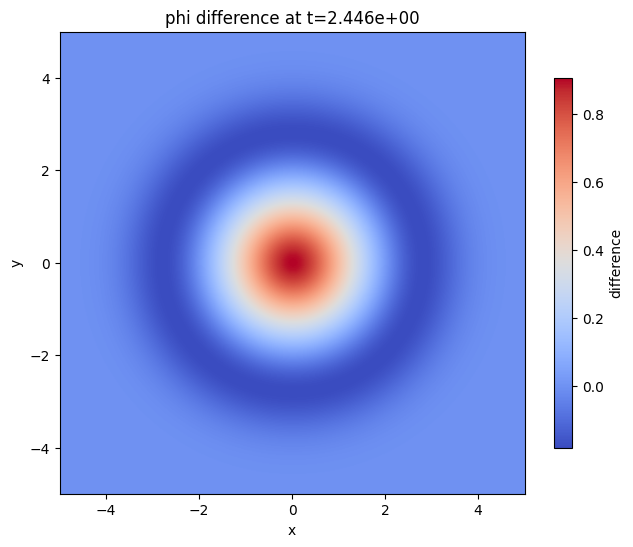

In [6]:
if comparison_result is None:
    raise RuntimeError("Run the comparison cell above to produce metrics before plotting.")

last_step = int(comparison_result["steps"][-1])
last_time = float(comparison_result["times"][-1])
for var in comparison_result["variables"]:
    fig, ax = plot_field_difference(runs[0], runs[1], last_step, var)
    ax.set_title(f"{var} difference at t={last_time:.3e}")
    plt.show()


Calculating energy for FP64 (51 steps)...
Calculating energy for Block Floating Point (51 steps)...


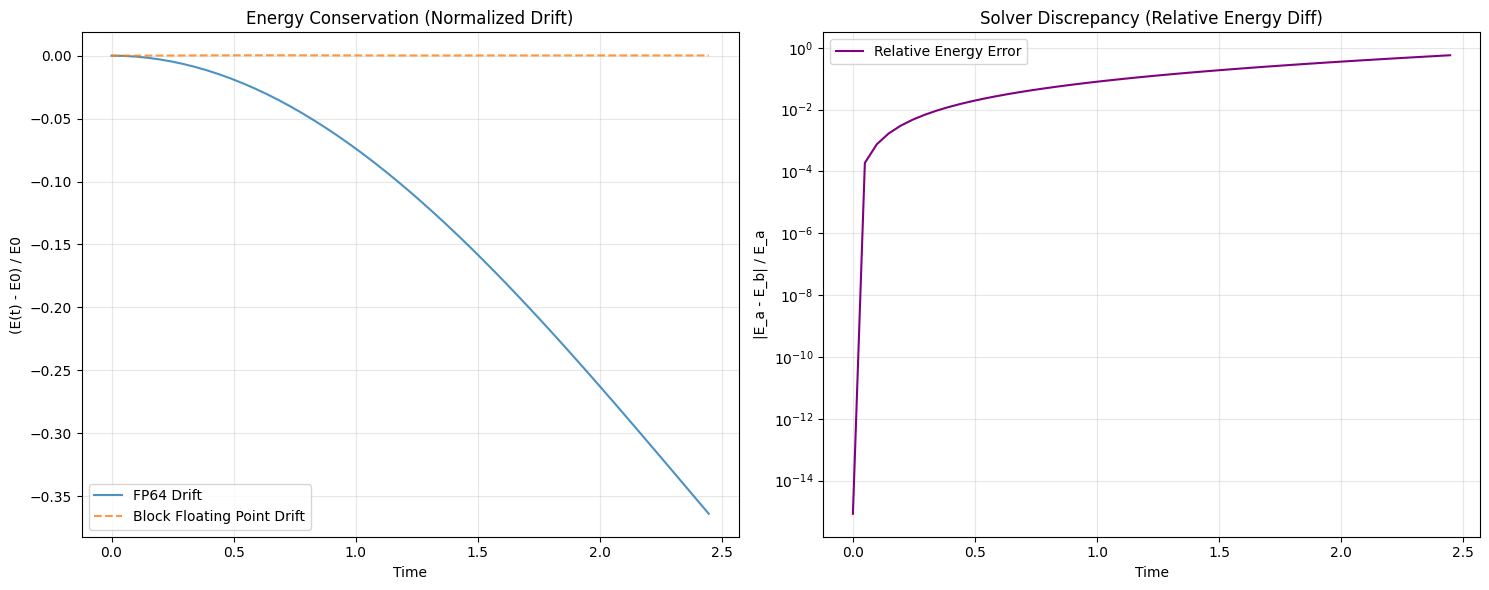

Final Relative Energy Difference: 5.7263e-01
Max Relative Energy Difference:   5.7263e-01


In [7]:
# Cell 7: Energy Analysis

def compute_energy_trajectory(run: SolverRunResult) -> Tuple[np.ndarray, np.ndarray]:
    """Computes total energy (Hamiltonian) for every output step."""
    
    # 1. Determine Grid Spacing
    # Assuming square pixels for simple integration
    x_axis = run.grid["X"]
    dx = float(x_axis[1] - x_axis[0])
    cell_area = dx * dx
    
    energies = []
    times = []
    
    # 2. Iterate through all output steps
    sorted_steps = sorted(run.file_map.keys())
    print(f"Calculating energy for {run.name} ({len(sorted_steps)} steps)...")
    
    for step in sorted_steps:
        # Load fields (phi, chi)
        data = _load_fields(run.file_map[step], ("phi", "chi"))
        phi, chi = data["phi"], data["chi"]
        
        # 3. Calculate Energy Density
        # Kinetic Energy: T = 0.5 * chi^2
        T = 0.5 * chi**2
        
        # Potential Energy: V = 0.5 * |grad(phi)|^2
        # np.gradient uses central differences, consistent with post-processing
        dphi_x = np.gradient(phi, dx, axis=0)
        dphi_y = np.gradient(phi, dx, axis=1)
        V = 0.5 * (dphi_x**2 + dphi_y**2)
        
        # 4. Integrate total Energy
        total_E = np.sum(T + V) * cell_area
        
        energies.append(total_E)
        times.append(step * run.dt)
        
    return np.array(times), np.array(energies)

# --- Execute Analysis ---
if len(runs) >= 2:
    # Compute Energies
    t_a, E_a = compute_energy_trajectory(runs[0])
    t_b, E_b = compute_energy_trajectory(runs[1])
    
    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Energy Drift (Conservation Check)
    # Shows how well each solver conserves energy individually
    # (E(t) - E(0)) / E(0)
    drift_a = (E_a - E_a[0]) / E_a[0]
    drift_b = (E_b - E_b[0]) / E_b[0]
    
    ax1.plot(t_a, drift_a, label=f"{runs[0].name} Drift", linestyle="-", alpha=0.8)
    ax1.plot(t_b, drift_b, label=f"{runs[1].name} Drift", linestyle="--", alpha=0.8)
    ax1.set_title("Energy Conservation (Normalized Drift)")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("(E(t) - E0) / E0")
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Relative Energy Discrepancy
    # Shows the physical disagreement between the two solvers
    # |E_a - E_b| / E_a
    # We must interpolate if time points don't perfectly align, 
    # but here they should match if output_interval is same.
    min_len = min(len(E_a), len(E_b))
    rel_diff = np.abs(E_a[:min_len] - E_b[:min_len]) / E_a[:min_len]
    common_times = t_a[:min_len]
    
    ax2.plot(common_times, rel_diff, color="purple", label="Relative Energy Error")
    ax2.set_title("Solver Discrepancy (Relative Energy Diff)")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("|E_a - E_b| / E_a")
    ax2.set_yscale("log")
    ax2.grid(True, alpha=0.3, which="both")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Final Relative Energy Difference: {rel_diff[-1]:.4e}")
    print(f"Max Relative Energy Difference:   {np.max(rel_diff):.4e}")

else:
    print("Need at least two runs to compare energy.")